<a href="https://colab.research.google.com/github/RodrickGulu/Final_Year_Project/blob/main/training_model_without_image_filter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


There were 1658 glaucomatous images and 1159 normal images from the dataset


Epoch 1/20
99/99 [==============================] - ETA: 0s - loss: 1.0517 - accuracy: 0.8747
Epoch 1: val_accuracy improved from -inf to 0.89480, saving model to /content/drive/MyDrive/vgg19_glaucoma.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


99/99 [==============================] - 21s 205ms/step - loss: 1.0517 - accuracy: 0.8747 - val_loss: 0.9812 - val_accuracy: 0.8948
Epoch 2/20
99/99 [==============================] - ETA: 0s - loss: 0.2377 - accuracy: 0.9696
Epoch 2: val_accuracy improved from 0.89480 to 0.90662, saving model to /content/drive/MyDrive/vgg19_glaucoma.h5
99/99 [==============================] - 19s 190ms/step - loss: 0.2377 - accuracy: 0.9696 - val_loss: 0.8126 - val_accuracy: 0.9066
Epoch 3/20
99/99 [==============================] - ETA: 0s - loss: 0.1210 - accuracy: 0.9782
Epoch 3: val_accuracy improved from 0.90662 to 0.91489, saving model to /content/drive/MyDrive/vgg19_glaucoma.h5
99/99 [==============================] - 24s 244ms/step - loss: 0.1210 - accuracy: 0.9782 - val_loss: 0.9347 - val_accuracy: 0.9149
Epoch 4/20
99/99 [==============================] - ETA: 0s - loss: 0.0660 - accuracy: 0.9878
Epoch 4: val_accuracy improved from 0.91489 to 0.91962, saving model to /content/drive/MyDrive/v

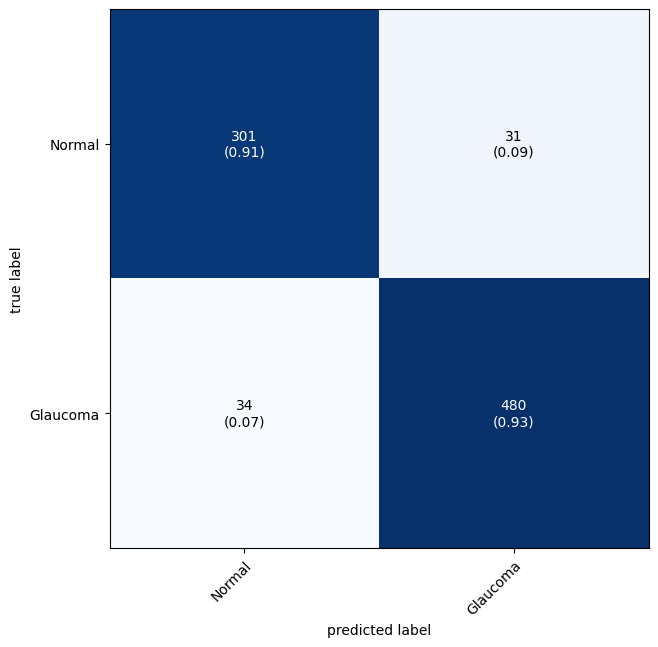

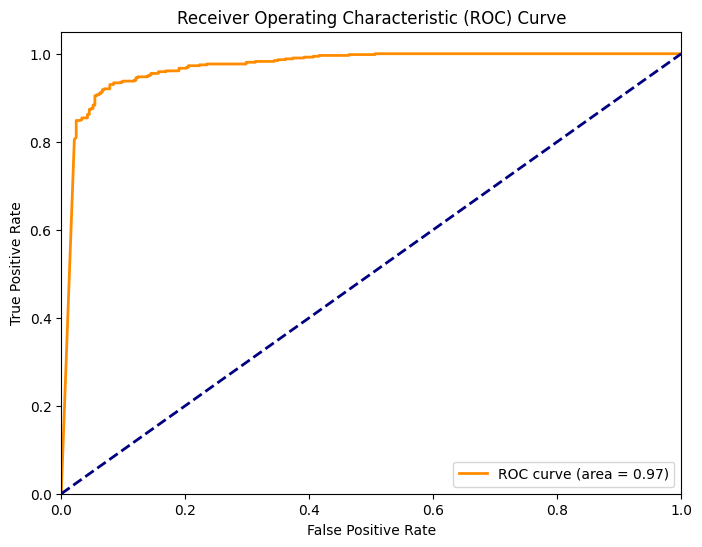

In [4]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from mlxtend.plotting import plot_confusion_matrix
import matplotlib.pyplot as plt
import random

def load_images_from_folder(folder_path):
    images = []
    labels = []

    for folder_name in os.listdir(folder_path):
        folder = os.path.join(folder_path, folder_name)
        if not os.path.isdir(folder):
            continue

        label = 1 if folder_name == "glaucoma" else 0

        for filename in os.listdir(folder):
            img_path = os.path.join(folder, filename)
            img = cv2.imread(img_path)
            img = cv2.resize(img, (224, 224))
            if img is not None:
                images.append(img)
                labels.append(label)

    return np.array(images), np.array(labels)

# Load images from the folder
dataset_path = '/content/drive/MyDrive/glaucoma_dataset/training'
images, labels = load_images_from_folder(dataset_path)

print(f"There were {np.count_nonzero(labels == 1)} glaucomatous images and {np.count_nonzero(labels == 0)} normal images from the dataset")

# Split the data into training and testing sets
glaucoma_dataset = list(zip(images, labels))

x = np.array([i[0] for i in glaucoma_dataset]).reshape(-1, 224, 224, 3)
y = np.array([i[1] for i in glaucoma_dataset])

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3)

# Defining the VGG19 model
vgg = VGG19(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

for layer in vgg.layers:
    layer.trainable = False

# Model architecture
model = Sequential()
model.add(vgg)
model.add(Flatten())
model.add(Dense(1, activation="sigmoid"))

model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

# Model callbacks
checkpoint = ModelCheckpoint("/content/drive/MyDrive/vgg19_glaucoma.h5", monitor="val_accuracy", verbose=1, save_best_only=True,save_weights_only=False, period=1)
earlystop = EarlyStopping(monitor="val_accuracy", patience=10, verbose=1)
callbacks = [checkpoint, earlystop]

# Training the model
history = model.fit(x_train, y_train, batch_size=20, epochs=20, validation_data=(x_test, y_test), verbose=1, callbacks=callbacks)

# Evaluating the model
loss, accuracy = model.evaluate(x_test, y_test)
print("Loss:", loss)
print("Accuracy:", accuracy)

y_pred = (model.predict(x_test) > 0.5).astype(int)
print("Accuracy Score:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(conf_mat=cm, figsize=(8, 7), class_names=["Normal", "Glaucoma"], show_normed=True)

# ROC curve
from sklearn.metrics import roc_curve, auc

y_probs = model.predict(x_test).ravel()
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

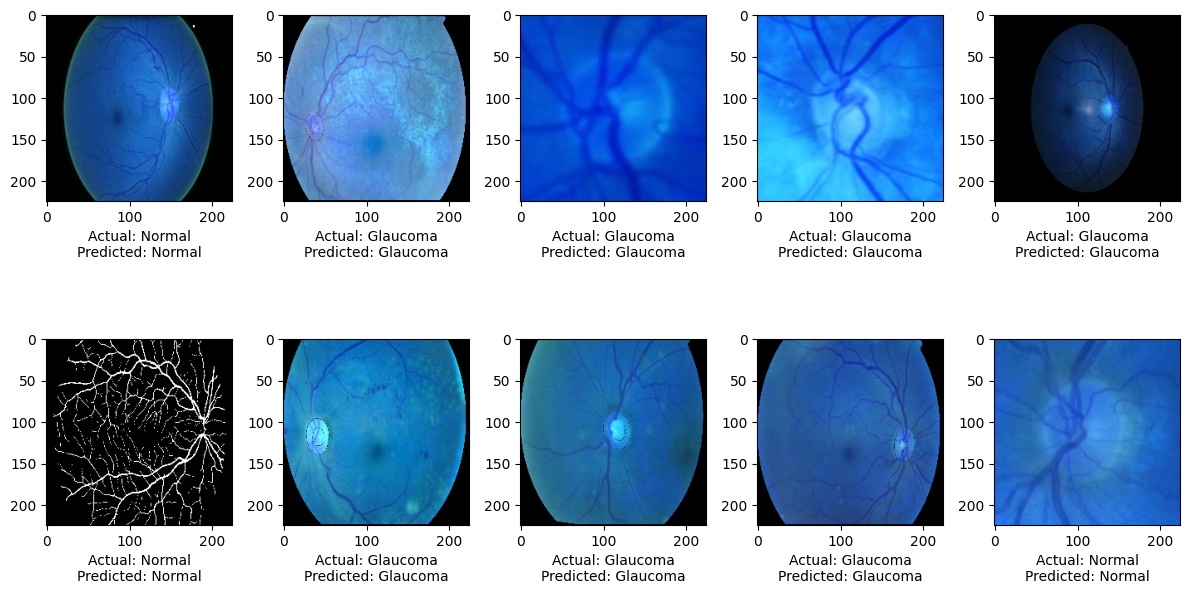

In [5]:
#samples images with the predicted and actual label
plt.figure(figsize=(12, 7))
for i in range(10):
    sample = random.choice(range(len(x_test)))
    image = x_test[sample]
    category = y_test[sample]
    pred_category = y_pred[sample]

    label = "Normal" if category == 0 else "Glaucoma"
    pred_label = "Normal" if pred_category == 0 else "Glaucoma"

    plt.subplot(2, 5, i + 1)
    plt.imshow(image)
    plt.xlabel(f"Actual: {label}\nPredicted: {pred_label}")
plt.tight_layout()
plt.show()

In [ ]:
# Save the model
model.save('/content/drive/MyDrive/glaucoma_classification_model.keras')